# Bayesian Inference in the Poisson Generalized Linear Model

**References:**
- Chapter 16 of BDA3 contains background material on generalized linear models.
- Chapter 7.1 of BDA3 introduces notation for model evaluation based on predictive log likelihoods.

## The Poisson GLM

The Poisson distribution is a common model for count data with a single parameter $\lambda \in \mathbb{R}_+$. Its pmf is,

\begin{align}
\Pr(y \mid \lambda) &= \frac{1}{y!} e^{-\lambda} \lambda^y,
\end{align}

for $y \in \mathbb{N}$. Its mean and variance are both equal to $\lambda$.

Suppose we have count observations $y_n \in \mathbb{N}$ along with covariates $x_n \in \mathbb{R}^P$. We construct a Poisson GLM by modeling the expected value as,

\begin{align}
\mathbb{E}[y_n \mid x_n] = f(w^\top x_n),
\end{align}

with $w \in \mathbb{R}^P$ and $f: \mathbb{R} \to \mathbb{R}_+$ is the mean function. The _canonical mean function_ is $f(a) = e^a$; equivalently, the canonical _link_ function is the logarithm.


We assume a Gaussian prior on the weights $w$:
$$
w \sim \mathcal{N}(0, \sigma^2 I),
$$

where $\sigma^2 I$ is the covariance matrix.

Derive the log joint probability,
 
\begin{align}
\mathcal{L}(w) &\triangleq \log p(\{y_n\}_{n=1}^N, w \mid \{x_n\}_{n=1}^N, \sigma^2) \\
&= \log p(w\mid\sigma^2) + \sum_{n=1}^N\log p(y_n \mid w^Tx_n)
\end{align}

If we replace $\lambda = \exp(w^Tx_n)$ in the Possion pmf we get

\begin{align}
\mathcal{L}(w) &= \log\mathcal{N}(w\mid 0, \sigma^2\mathbf{I})+\sum_{n=1}^N\log\left(\frac{1}{y_n!}\exp\left\{\left \langle y_n, w^Tx_n \right \rangle-\exp(w^Tx_n)\right\}\right)\\
&= \log\mathcal{N}(w\mid 0, \sigma^2\mathbf{I}) + \sum_{n=1}^N\left(\left \langle y_n, w^Tx_n \right \rangle - \exp(w^Tx_n) - \log (y_n!)\right)\\
&= -\frac{w^Tw}{2\sigma^2} + \left \langle \sum_{n=1}^Ny_nx_n, w \right \rangle - \sum_{n=1}^N\exp(w^Tx_n) + C
\end{align}

\begin{align}
\nabla_w \mathcal{L}(w) &= -\nabla_w\frac{w^Tw}{2\sigma^2} +  \nabla_w\left \langle \sum_{n=1}^Ny_nx_n, w \right \rangle -  \nabla_w\sum_{n=1}^N\exp(w^Tx_n)\\
&= -\frac{w}{\sigma^2}+\sum_{n=1}^Ny_nx_n-\sum_{n=1}^Nx_n\exp(w^Tx_n)
\end{align}

\begin{align}
\nabla^2_w \mathcal{L}(w) &= -\nabla_w\frac{w}{\sigma^2}+\nabla_w\sum_{n=1}^Ny_nx_n-\nabla_w\sum_{n=1}^Nx_n\exp(w^Tx_n)\\
&= -\frac{I}{\sigma^2}+0-\sum_{n=1}^Nx_n\nabla_w\exp(w^Tx_n)\\
&= -\frac{I}{\sigma^2}-\sum_{n=1}^Nx_nx_n^T\exp(w^Tx_n)
\end{align}

## Maximum a posterior (MAP) Estimation

### Optimize to find the posterior mode

In [1]:
import sys
sys.path.append('../')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.d01_data.dengue_data_api import DengueDataApi
from src.d04_modeling.poisson_glm import PoissonGLM

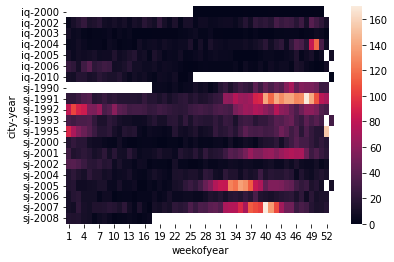

In [2]:
dda = DengueDataApi()
x_train, x_validate, y_train, y_validate = dda.split_data()

axs0 = sns.heatmap(y_train.unstack('weekofyear'))

In [3]:
sigma2 = 1.
poisson_glm1 = PoissonGLM(x_train=x_train, y_train=y_train, sigma2=sigma2)

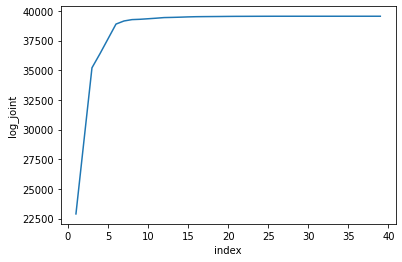

In [4]:
_, w_hist = poisson_glm1.compute_posterior_mode()
w_hist_df = pd.DataFrame(w_hist, columns=x_train.columns)
w_hist_df['log_joint'] = w_hist_df.apply(lambda w: poisson_glm1.log_joint(y_train.values.reshape((-1,1)),
                                                                          x_train.values, 1.,
                                                                            w.values, sigma2), axis=1)
w_hist_df.name = 'iter'
axs1 = sns.lineplot(data=w_hist_df.iloc[1:].reset_index(), x="index", y="log_joint")

## Laplace Approximation



### Approximate the covariance at the mode

Solve for $\Sigma_{\mathsf{MAP}} = -[\nabla^2(\mathcal{L}(w_{\mathsf{MAP}})]^{-1}$. Plot the covariance matrix (e.g. with `imshow`). Don't forget to add a colorbar and labels.

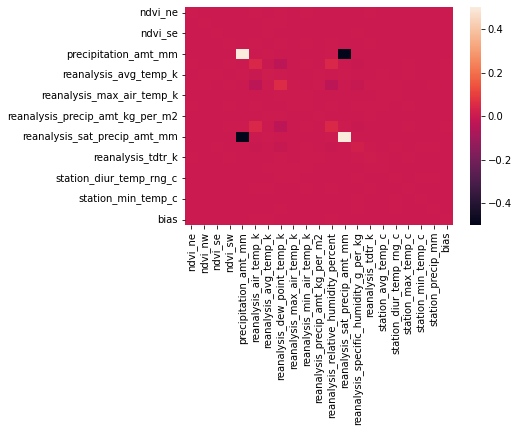

In [5]:
poisson_glm1.compute_laplace_approximation()
cov_map = poisson_glm1.get_cov_map()
cov_map_df = pd.DataFrame(cov_map, index=x_train.columns, columns=x_train.columns)
axs2 = sns.heatmap(cov_map_df)

# Posterior of the weights

Plot the posterior mean of the weights for features $x_n$ (i.e. not including the bias term). Also plot 95% credible intervals around the mean by using two standard deviations of the marginal distribution of the weights. Note the diagonal of $\Sigma_{\mathsf{MAP}}$ gives the marginal variance of the posterior. 

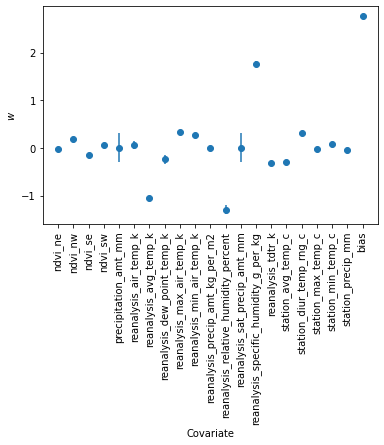

In [6]:
w_map = poisson_glm1.get_w_map()
var_map = np.diagonal(cov_map)

fig, ax = plt.subplots()
n = len(var_map)
ax.errorbar(range(n), w_map, yerr=1.96*np.sqrt(var_map/n), marker='o', linestyle='none')
ax.set_xlabel('Covariate')
ax.set_xticks(range(n))
ax.set_xticklabels(x_train.columns, rotation='vertical')
ax.set_ylabel('$w$')
plt.show()

## Model validation

### Approximate the posterior predictive distribution of the rates

We can draw many samples $w^{(s)}$ from the Laplace approximation of the posterior $p(w \mid \{x_n, y_n\})$. Use those samples to approximate the posterior predictive distribution on the **test** dataset,

\begin{align}
p(y_{n'}=k \mid x_{n'}, \{x_n, y_n\}_{n=1}^N) &= 
\int p(y_{n'} \mid w, x_{n'}) \, p(w \mid \{x_n, y_n\}_{n=1}^N) \, \mathrm{d} w \\
&\approx \frac{1}{S} \sum_{s=1}^S p(y_{n'}=k \mid w^{(s)}, x_{n'})
\end{align}
where
\begin{align}
w^{(s)} &\sim p(w \mid \{x_n, y_n\}_{n=1}^N \\
&\approx \mathcal{N}(w \mid w_{\mathsf{MAP}}, \Sigma_{\mathsf{MAP}})
\end{align}

Visualize the posterior predictive distribution as an $K \times N_{\mathsf{test}}$ array where row corresponds to possible spike counts $k\in \{0,\ldots, K\}$. You can set $K=5$ for this problem. **Only show the first 100 columns (time bins), otherwise it's hard to see changes in the rate.**

Overlay the actual spike counts for the test dataset. 

Sampling posterior predictive distribution...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 23.55it/s]


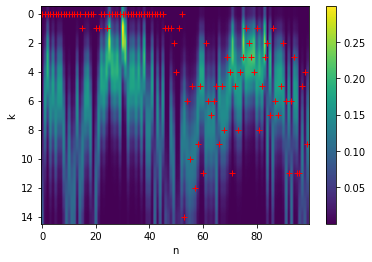

Log Joint Probability: 46646.65
MAE: 24.442308


In [7]:
log_joint, mae, e = poisson_glm1.validate_model(x_validate=x_validate, y_validate=y_validate)
print("Log Joint Probability: %.2f" % log_joint)
print("MAE: %.6f" % mae)

## Singular Value Descomposition


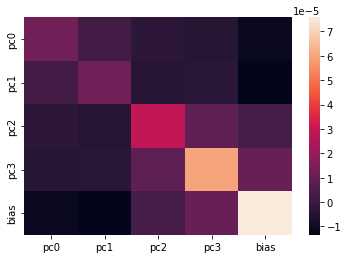

In [8]:
x_train, x_validate, y_train, y_validate = dda.split_data()

u, s, vh = np.linalg.svd(x_train, full_matrices=True)
num_components = 4
new_features = ["pc%i" % i for i in range(num_components)]
z_train = pd.DataFrame(np.dot(x_train, vh[:num_components, :].T), columns=new_features, index=x_train.index)
z_validate = pd.DataFrame(np.dot(x_validate, vh[:num_components, :].T), columns=new_features, index=x_validate.index)

sigma2 = 1.
poisson_glm2 = PoissonGLM(x_train=z_train, y_train=y_train, sigma2=sigma2)

poisson_glm2.compute_laplace_approximation()
cov_map = poisson_glm2.get_cov_map()
cov_map_df = pd.DataFrame(cov_map, index=z_train.columns, columns=z_train.columns)
axs2 = sns.heatmap(cov_map_df)

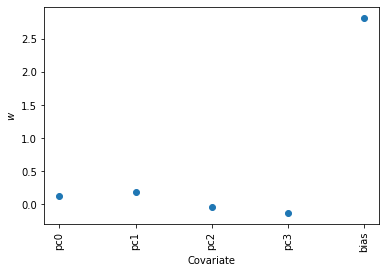

In [9]:
w_map = poisson_glm2.get_w_map()
var_map = np.diagonal(cov_map)

fig, ax = plt.subplots()
n = len(var_map)
ax.errorbar(range(n), w_map, yerr=1.96*np.sqrt(var_map), marker='o', linestyle='none')
ax.set_xlabel('Covariate')
ax.set_xticks(range(n))
ax.set_xticklabels(z_train.columns, rotation='vertical')
ax.set_ylabel('$w$')
plt.show()

Sampling posterior predictive distribution...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 30.92it/s]


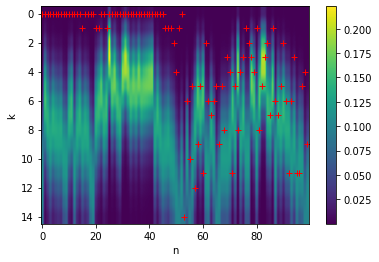

Log Joint Probability: 46100.16
MAE: 24.957692


In [10]:
log_joint, mae, e = poisson_glm2.validate_model(x_validate=z_validate, y_validate=y_validate)
print("Log Joint Probability: %.2f" % log_joint)
print("MAE: %.6f" % mae)